# Note about PyOD

    - PyOD is a comprehensive and scalable Python toolkit for detecting outlying objects in multivariate data. See https://pyod.readthedocs.io/en/latest/# for details. 
    - pip install pyod for installing PyOD
    - PyOD supports nearly 30 different alogorithms just for anamoly detection
    
    Zhao, Y., Nasrullah, Z. and Li, Z., 2019. PyOD: A Python Toolbox for Scalable Outlier Detection. arXiv preprint arXiv:1901.01588.


In [1]:
from pyod.utils.data import generate_data

def initialize():
    
    contamination = 0.1
    n_train_samples = 20000
    n_test_samples = 4000
    n_features = 30
    
    trainX, trainY, testX, testY = generate_data(n_train=n_train_samples, 
                                                 n_features=n_features, 
                                                 n_test=n_test_samples, 
                                                 contamination=contamination)
    return trainX, trainY, testX, testY

trainX, trainY, testX, testY = initialize()

C:\MachineLearning\anaconda\lib\site-packages\pyod\utils\data.py:190: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.7.2. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


In [2]:
from pyod.utils.data import evaluate_print

def evaluate_classifier(clf, testX, testY, trainY):
    
    '''
    Params:
    
    clf - classifiers through which we find labels and decision scores
    '''
    #get the labels (outlier/inlier label) for training data
    training_labels = clf.labels_

    #get the decision score for training data & visualize
    training_scores = clf.decision_scores_
    testing_scores = clf.decision_function(testX)

    # In an unsupervised setup, we would not have target labels so there is no point in predicting the
    # labels for testX and comparing it against the actual labels. Assuming we would have had the target
    # labels then we could have done the below:

    # Apply metrics like F1 score to evaluate the performance of this algorithm
    print ('\n On training data we got')
    evaluate_print('KNN', trainY, training_scores)

    print ('\n On testing data we got')
    evaluate_print('KNN', testY, testing_scores)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline

def visualize_outliers(trainX, training_scores):
    '''
    Parameters:
    
    training_score - decision score on training data
    
    '''
    
    # Find all data points which have a score greater than threshold
    n_outliers = 10
    training_score_as_series = pd.Series(training_scores)
    threshold = np.min(training_score_as_series.nlargest(n=n_outliers, keep='first'))
    
    #For visualization pick any three features against which we can plot the outliers. On a real
    #scenario these features would either be derived from PCA or from the dataset itself. These
    #would be the most important features in the dataset.
    df = pd.DataFrame(data=list(zip(trainX[:,1],trainX[:,2],trainX[:,3])), columns=['X1','X2','X3'])
    df['anamoly_scores']=training_scores
    df['anamoly'] = (df['anamoly_scores'] >=threshold).astype(int)
    
    colors = {0:'blue', 1:'red'}
    fig = plt.figure(1, figsize=(7,7))
    ax = Axes3D(fig, rect=[0,0,0.95,1], elev=48, azim=134)
    ax.scatter(df['X1'],df['X2'],df['X3'], c= df['anamoly'].apply(lambda x: colors[x]), edgecolors='k')
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    ax.set_zlabel('feature 3')
    plt.title('Outliers')
    plt.show()

# Section A - Outlier detection using KNN

    - Classifier metrics


 On training data we got
KNN ROC:1.0, precision @ rank n:1.0

 On testing data we got
KNN ROC:1.0, precision @ rank n:1.0


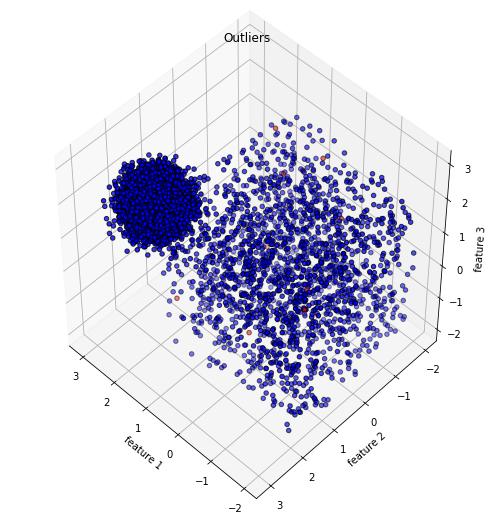

In [4]:
from pyod.models.knn import KNN

# initialize model
knnClassifier = KNN ()

#train on training data
knnClassifier.fit(trainX)

predictions = knnClassifier.labels_
y_train_scores = knnClassifier.decision_scores_

evaluate_classifier(knnClassifier, testX, testY, trainY)
visualize_outliers(trainX, y_train_scores)

# Section B - Outlier detection using Local Outlier Factor (LOF)


 On training data we got
KNN ROC:0.2141, precision @ rank n:0.0

 On testing data we got
KNN ROC:0.2261, precision @ rank n:0.0


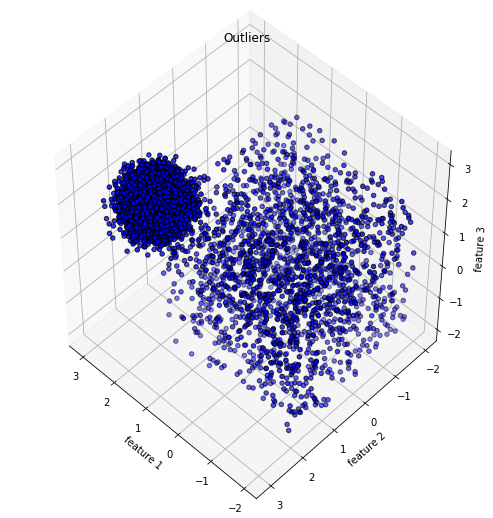

In [5]:
from pyod.models.lof import LOF

# initialize model
lofClassifier = LOF (n_neighbors=10, algorithm='auto', metric='minkowski')

#train on training data
lofClassifier.fit(trainX)

predictions = lofClassifier.labels_
y_train_scores = lofClassifier.decision_scores_

evaluate_classifier(lofClassifier, testX, testY, trainY)
visualize_outliers(trainX, y_train_scores)

# Section C - Outlier detection using Isolation Forest

C:\MachineLearning\anaconda\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished



 On training data we got
KNN ROC:1.0, precision @ rank n:1.0

 On testing data we got
KNN ROC:1.0, precision @ rank n:1.0


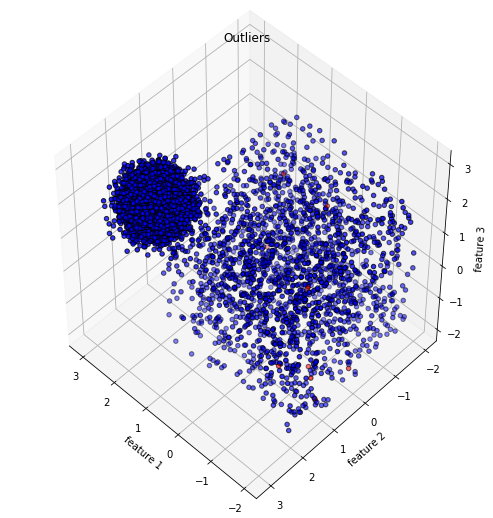

In [6]:
from pyod.models.iforest import IForest

# initialize model
ifClassifier = IForest (n_estimators=200, 
                        max_samples='auto', 
                        max_features=30, 
                        contamination=0.1,
                        random_state=99, 
                        verbose=1)

#train on training data
ifClassifier.fit(trainX)

predictions = ifClassifier.labels_
y_train_scores = ifClassifier.decision_scores_
threshold = ifClassifier.threshold_

evaluate_classifier(ifClassifier, testX, testY, trainY)
visualize_outliers(trainX, y_train_scores)

# Section D - Outlier detection using Feature Bagging


 On training data we got
KNN ROC:0.1372, precision @ rank n:0.0

 On testing data we got
KNN ROC:0.1483, precision @ rank n:0.0


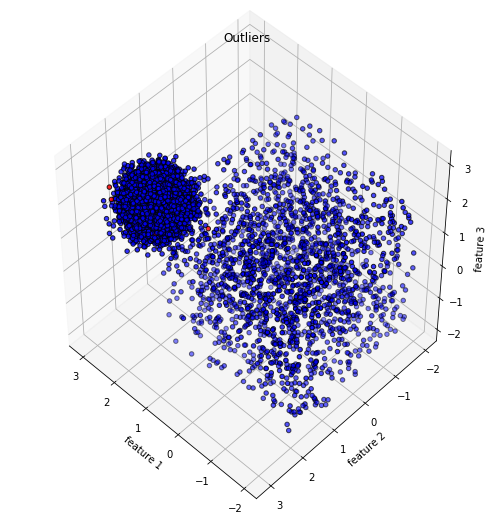

In [7]:
from pyod.models.feature_bagging import FeatureBagging

# initialize model
fbClassifier = FeatureBagging (n_estimators=100, 
                               n_jobs=-1, 
                               bootstrap_features=True, 
                               max_features=30, 
                               random_state=99, 
                               verbose=1)

#train on training data
fbClassifier.fit(trainX)

predictions = fbClassifier.labels_
y_train_scores = fbClassifier.decision_scores_

evaluate_classifier(fbClassifier, testX, testY, trainY)
visualize_outliers(trainX, y_train_scores)

# Summary

    - We find that for dataset of n_train=20000, n_features=20, n_test=2000, contamination=0.1
        - Isolation Forest produces best result even without any hyperparameter tuning